In [94]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

03:14:55 - cmdstanpy - INFO - Chain [1] start processing
03:14:56 - cmdstanpy - INFO - Chain [1] done processing


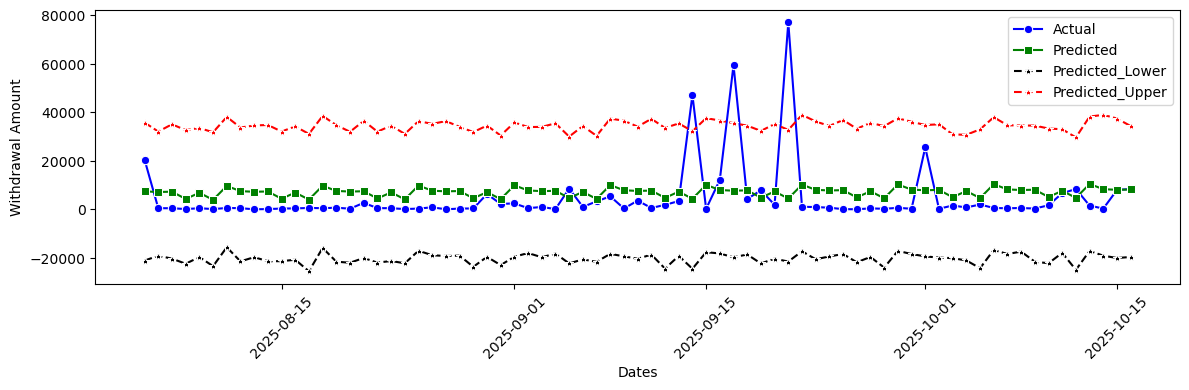

In [96]:
path = "OpTransactionHistoryFrom_Oct-24toOct-25.csv"
df = pd.read_csv(path)

df = df[["Transaction Date","Withdrawal Amount(INR)","Balance(INR)","Deposit Amount(INR)"]].rename(columns={
    "Transaction Date":"date",
    "Withdrawal Amount(INR)":'withdrawal',
    "Balance(INR)":"balance",
    "Deposit Amount(INR)":"deposit"
}).dropna()
df['date'] = pd.to_datetime(df['date'], format='%d,%m,%Y')
daily_df = df.groupby('date').agg({
    'withdrawal': 'sum',
    'deposit': 'sum',
    'balance': 'last'
}).reset_index()
full_range = pd.date_range(daily_df['date'].min(), daily_df['date'].max())
daily_df = daily_df.set_index('date').reindex(full_range)
daily_df[['withdrawal', 'deposit']] = daily_df[['withdrawal', 'deposit']].fillna(0)
daily_df['balance'] = daily_df['balance'].ffill().bfill()
daily_df = daily_df.reset_index().rename(columns={'index': 'date'})

withdrawal_df = daily_df[['date', 'withdrawal']].rename(columns={'date': 'ds', 'withdrawal': 'y'})
deposit_df = daily_df[['date', 'deposit']].rename(columns={'date': 'ds', 'deposit': 'y'})
balance_df = daily_df[['date', 'balance']].rename(columns={'date': 'ds', 'balance': 'y'})

m = Prophet(
    changepoint_prior_scale=0.1, # flexibility of trend changes (higher = more flexible)
)

split_index = int(len(withdrawal_df)*0.80)
withdrawal_df_train = withdrawal_df[:split_index]
withdrawal_df_test = withdrawal_df[split_index:]

m.fit(withdrawal_df_train)
test_dates = pd.DataFrame({'ds':withdrawal_df_test['ds']})
withdrawal_forecast = m.predict(test_dates)
comparison_df = pd.DataFrame({
    'Date': withdrawal_df_test['ds'],
    'Actual': withdrawal_df_test['y'].values,
    'Predicted': withdrawal_forecast['yhat'].values,
    'Predicted_Lower':withdrawal_forecast['yhat_lower'].values,
    'Predicted_Upper':withdrawal_forecast['yhat_upper'].values
})
plt.figure(figsize=(12,4))
sns.lineplot(data=comparison_df, x='Date', y='Actual', label='Actual', marker='o', color='blue')
sns.lineplot(data=comparison_df, x='Date', y='Predicted', label='Predicted', marker='s', color='green')
sns.lineplot(data=comparison_df, x='Date', y='Predicted_Lower', label='Predicted_Lower', marker='*', color='black', linestyle="--")
sns.lineplot(data=comparison_df, x='Date', y='Predicted_Upper', label='Predicted_Upper', marker='*', color='red', linestyle="--")
plt.xlabel('Dates')
plt.ylabel('Withdrawal Amount')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

03:20:11 - cmdstanpy - INFO - Chain [1] start processing



==================== WITHDRAWAL FORECAST ====================


03:20:11 - cmdstanpy - INFO - Chain [1] done processing


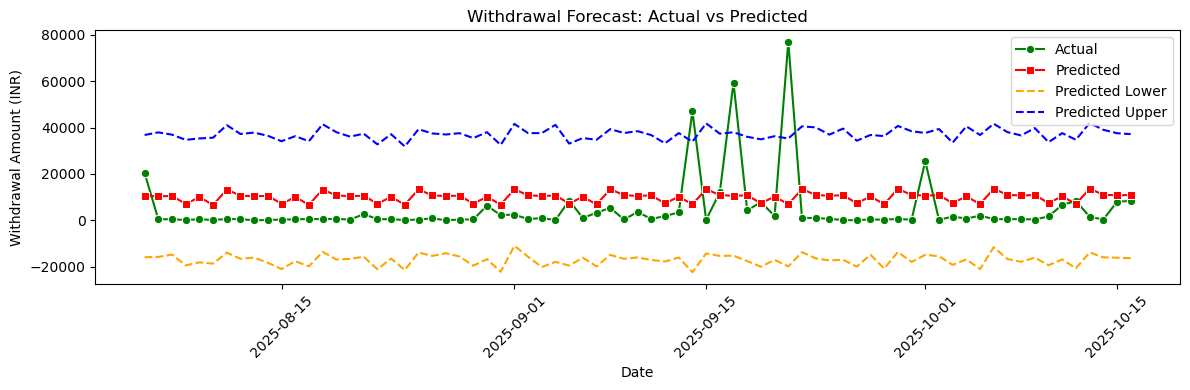

03:20:12 - cmdstanpy - INFO - Chain [1] start processing



==================== DEPOSIT FORECAST ====================


03:20:13 - cmdstanpy - INFO - Chain [1] done processing


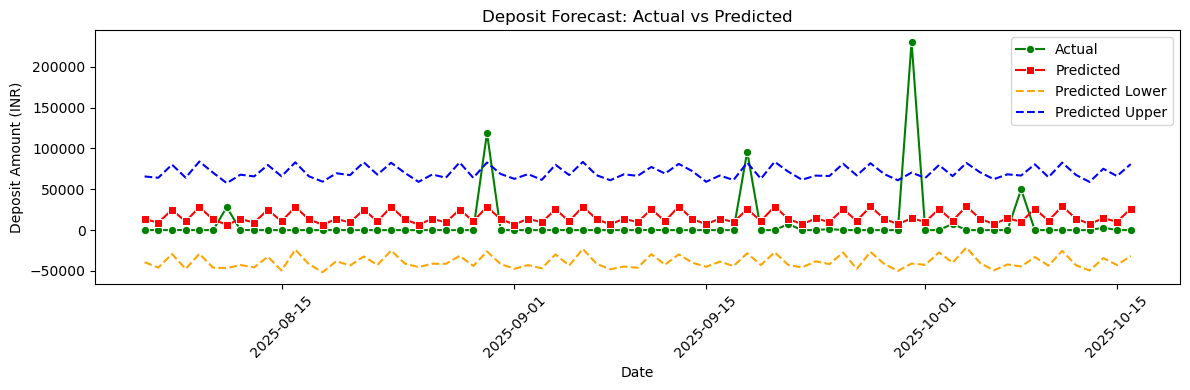

03:20:13 - cmdstanpy - INFO - Chain [1] start processing



==================== BALANCE FORECAST ====================


03:20:14 - cmdstanpy - INFO - Chain [1] done processing


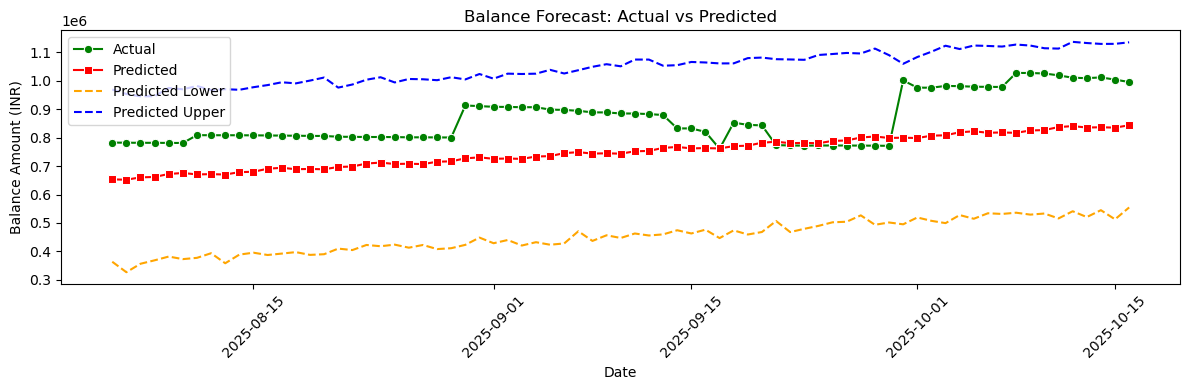

In [103]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# STEP 1: Load & Prepare Data
# ======================
path = "OpTransactionHistoryFrom_Oct-24toOct-25.csv"
df = pd.read_csv(path)

df = df[["Transaction Date", "Withdrawal Amount(INR)", "Balance(INR)", "Deposit Amount(INR)"]].rename(columns={
    "Transaction Date": "date",
    "Withdrawal Amount(INR)": "withdrawal",
    "Balance(INR)": "balance",
    "Deposit Amount(INR)": "deposit"
}).dropna()

# Convert date
df['date'] = pd.to_datetime(df['date'], format='%d,%m,%Y')

# Aggregate daily
daily_df = df.groupby('date').agg({
    'withdrawal': 'sum',
    'deposit': 'sum',
    'balance': 'last'
}).reset_index()

# Fill missing dates
full_range = pd.date_range(daily_df['date'].min(), daily_df['date'].max())
daily_df = daily_df.set_index('date').reindex(full_range)
daily_df[['withdrawal', 'deposit']] = daily_df[['withdrawal', 'deposit']].fillna(0)
daily_df['balance'] = daily_df['balance'].ffill().bfill()
daily_df = daily_df.reset_index().rename(columns={'index': 'date'})

# Prophet-format dataframes
withdrawal_df = daily_df[['date', 'withdrawal']].rename(columns={'date': 'ds', 'withdrawal': 'y'})
deposit_df = daily_df[['date', 'deposit']].rename(columns={'date': 'ds', 'deposit': 'y'})
balance_df = daily_df[['date', 'balance']].rename(columns={'date': 'ds', 'balance': 'y'})

# ======================
# STEP 2: Helper Function to Train, Predict, Plot
# ======================
def prophet_forecast_plot(df, label):
    """
    Fits Prophet model, predicts on test split, and plots Actual vs Predicted.
    """
    print(f"\n==================== {label.upper()} FORECAST ====================")
    
    # Train/Test Split (80%)
    split_index = int(len(df) * 0.8)
    train_df = df[:split_index]
    test_df = df[split_index:]
    
    # Model initialization
    m = Prophet(
        changepoint_prior_scale=0.001   # very low flexibility
       
    )
    
    # Fit model
    m.fit(train_df)
    
    # Predict on test dates
    test_dates = pd.DataFrame({'ds': test_df['ds']})
    forecast = m.predict(test_dates)
    
    # Combine actual and predicted
    comparison_df = pd.DataFrame({
        'Date': test_df['ds'],
        'Actual': test_df['y'].values,
        'Predicted': forecast['yhat'].values,
        'Predicted_Lower': forecast['yhat_lower'].values,
        'Predicted_Upper': forecast['yhat_upper'].values
    })
    
    # Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=comparison_df, x='Date', y='Actual', label='Actual', marker='o', color='green')
    sns.lineplot(data=comparison_df, x='Date', y='Predicted', label='Predicted', marker='s', color='red')
    sns.lineplot(data=comparison_df, x='Date', y='Predicted_Lower', label='Predicted Lower', linestyle="--", color='orange')
    sns.lineplot(data=comparison_df, x='Date', y='Predicted_Upper', label='Predicted Upper', linestyle="--", color='blue')
    plt.xlabel('Date')
    plt.ylabel(f'{label} Amount (INR)')
    plt.title(f'{label} Forecast: Actual vs Predicted')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# ======================
# STEP 3: Run Forecasts for All Three
# ======================
withdrawal_results = prophet_forecast_plot(withdrawal_df, "Withdrawal")
deposit_results = prophet_forecast_plot(deposit_df, "Deposit")
balance_results = prophet_forecast_plot(balance_df, "Balance")
